In [56]:
import requests
import json
import pandas as pd
import time
import re
import urllib
import matplotlib
import numpy as np
pd.set_option('display.max_colwidth', None)

In [57]:
address = "terra1w579ysjvpx7xxhckxewk8sykxz70gm48wpcuruenl29rhe6p6raslhj0m6"

In [58]:
def get_txs_time_period(_from, _to):
    _df = None
    timestamp = urllib.parse.quote(_from.strftime("%Y-%m-%d+%H:%M:%S"),safe='+')
    while True:
        url = f"""
        https://api.seer.coinhall.org/api/coinhall/swaps/{address}?offset={timestamp}.010646870&limit=15
        """
        print(url)
        # Send a GET request to the API
        response = requests.get(url)
    
        time.sleep(1)
        print(f"Number of txs received: {len(response.json()['txs'])}")
        
        new_df = pd.DataFrame(response.json()['txs'])
        if _df is None:
            _df = new_df
        else:
            _df = pd.concat([_df, new_df])
        _df.timestamp = pd.to_datetime(_df.timestamp)
        min_ts = _df.timestamp.min()
        timestamp = urllib.parse.quote(min_ts.strftime("%Y-%m-%d+%H:%M:%S"),safe='+')

        if(min_ts.to_pydatetime().replace(tzinfo=None) < _to):
            break
    return _df

In [59]:
from datetime import datetime, timedelta

current_date = datetime.now()
threshold_day = current_date - timedelta(days=40)

In [60]:
try:
    df = pd.read_csv("./data/astro/swaps.csv")
    df.timestamp = pd.to_datetime(df.timestamp, format='mixed')
except Exception as e:
    print(f"No file yet {e}")
    df = None

In [61]:
if df is None:
    print("No data yet. Downloading it all...")
    df = get_txs_time_period(current_date, threshold_day)
else:
    if df.timestamp.max().to_pydatetime().replace(tzinfo=None) < current_date:
        print(f"Filling the upper gap from {current_date.strftime('%Y-%m-%d')} to {df.timestamp.max().to_pydatetime().replace(tzinfo=None).strftime('%Y-%m-%d')}")
        tt_df = get_txs_time_period(current_date, df.timestamp.max().to_pydatetime().replace(tzinfo=None))
        df = pd.concat([df, tt_df])
    if df.timestamp.min().to_pydatetime().replace(tzinfo=None) > threshold_day:
        print(f"Filling the lower gap from {threshold_day.strftime('%Y-%m-%d')} to {df.timestamp.min().to_pydatetime().replace(tzinfo=None).strftime('%Y-%m-%d')}")
        tt_df = get_txs_time_period(df.timestamp.min().to_pydatetime().replace(tzinfo=None), threshold_day)
        df = pd.concat([df, tt_df])
df = df.drop_duplicates(ignore_index=True)

Filling the upper gap from 2023-07-13 to 2023-07-13

        https://api.seer.coinhall.org/api/coinhall/swaps/terra1w579ysjvpx7xxhckxewk8sykxz70gm48wpcuruenl29rhe6p6raslhj0m6?offset=2023-07-13+19%3A39%3A53.010646870&limit=15
        
Number of txs received: 15


In [62]:
assets = {
    'ibc/B3504E092456BA618CC28AC671A71FB08C6CA0FD0BE7C8A5B5A3E2DD933CC9E4':'axlUSDC',
    'terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26':'ASTRO'
}

In [63]:
df = df.drop_duplicates(ignore_index=True)
df.returnAsset = df.returnAsset.replace(assets)
df.offerAsset = df.offerAsset.replace(assets)

In [64]:
df['date'] = df.timestamp.apply(lambda x: x.strftime("%Y-%m-%d"))

In [65]:
df.to_csv(f'data/astro/swaps.csv', index=False)

In [66]:
astro_sell = df[df.offerAsset=='ASTRO']

In [67]:
astro_buy = df[df.returnAsset=='ASTRO']

In [68]:
astro_sell.head()

,txHash,timestamp,traderAddress,offerAsset,offerAmount,offerAssetUsdPrice,returnAsset,returnAmount,returnAssetUsdPrice,isHallSwap,usdVolume,date
0,FE01E7E53809EA79EC2715E3FF8D7257F7E1D7FAA313F69A85D6D9C0BB251BD6,2023-07-04 19:16:15.443000+00:00,terra1djkwwpgevx42h8j7zwtgtvy2zcd2z345n5kuhn,ASTRO,2.716330,0.026810,axlUSDC,0.072808,1.000239,False,0.072825,2023-07-04
1,FE01E7E53809EA79EC2715E3FF8D7257F7E1D7FAA313F69A85D6D9C0BB251BD6,2023-07-04 19:16:15.443000+00:00,terra1djkwwpgevx42h8j7zwtgtvy2zcd2z345n5kuhn,ASTRO,16.465340,0.026810,axlUSDC,0.441335,1.000239,False,0.441440,2023-07-04
2,9E66D50BC32283FE84AA95C9DD88024AD88DBA358BC45DBA15DD7332D69CBB84,2023-07-04 19:15:33.373000+00:00,terra1djkwwpgevx42h8j7zwtgtvy2zcd2z345n5kuhn,ASTRO,569.578058,0.026796,axlUSDC,15.267301,0.999693,False,15.262612,2023-07-04
3,9E66D50BC32283FE84AA95C9DD88024AD88DBA358BC45DBA15DD7332D69CBB84,2023-07-04 19:15:33.373000+00:00,terra1djkwwpgevx42h8j7zwtgtvy2zcd2z345n5kuhn,ASTRO,1064.903007,0.026798,axlUSDC,28.546487,0.999693,False,28.537719,2023-07-04
4,7FDFCACE399E6390C39BBA96B36FAC3F9D37F551EB6F71973716012A98336E7A,2023-07-04 19:15:03.564000+00:00,terra1djkwwpgevx42h8j7zwtgtvy2zcd2z345n5kuhn,ASTRO,13.645774,0.026800,axlUSDC,0.365817,0.999693,False,0.365705,2023-07-04


In [69]:
tt_sell = astro_sell[astro_sell.date >= '2023-07-01']\
    [['traderAddress','returnAmount','date']]\
    .groupby('traderAddress')\
    .agg(last_trade_date=('date', np.max),
         total_return_amount=('returnAmount', np.sum))\
    .sort_values(by='total_return_amount', ascending=False).reset_index().head(20)

tt_buy = astro_buy[astro_buy.date >= '2023-07-01']\
    [['traderAddress','returnAmount','date']]\
    .groupby('traderAddress')\
    .agg(last_trade_date=('date', np.max),
         total_return_amount=('returnAmount', np.sum))\
    .sort_values(by='total_return_amount', ascending=False).reset_index().head(20)

In [70]:
import requests
import json

def get_balances(address):
    url = "https://starscream-terra-mainnet.chainscope.dev/"
    headers = {
        "Content-Type": "application/json"
    }
    
    body = {
        "query": """
        query Query($address: String!, $tokenContracts: [String!]!) {
            tokenBalances(address: $address, tokenContracts: $tokenContracts)
        }
        """,
        "variables": {
            "address": f"{address}",
            "tokenContracts": [
                "terra1x62mjnme4y0rdnag3r8rfgjuutsqlkkyuh4ndgex0wl3wue25uksau39q8",
                "terra1xp9hrhthzddnl7j5du83gqqr4wmdjm5t0guzg9jp6jwrtpukwfjsjgy4f3",
                "terra19p20mfnvwh9yvyr7aus3a6z6g6uk28fv4jhx9kmnc2m7krg27q2qkfenjw",
                "terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26",
                "terra1ecgazyd0waaj3g7l9cmy5gulhxkps2gmxu9ghducvuypjq68mq2s5lvsct",
                "terra1lxx40s29qvkrcj8fsa3yzyehy7w50umdvvnls2r830rys6lu2zns63eelv",
                "terra17aj4ty4sz4yhgm08na8drc0v03v2jwr3waxcqrwhajj729zhl7zqnpc0ml"
            ]
        },
        "operationName": "Query"
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body))
    
    if response.status_code == 200:
        result = response.json()
        return result
    else:
        print("Request failed with status code:", response.status_code)

In [71]:
tokens = [
"xASTRO",
"SAYVE",
"ORNE",
"ASTRO",
"ampLUNA",
"ROAR",
"boneLuna"
]

In [72]:
balances_sell = []
for i, row in tt_sell.iterrows():
    address = row['traderAddress']
    balance_dict = {k: int(v)/1000000 for k, v in zip(tokens, get_balances(row['traderAddress'])['data']['tokenBalances'])}
    balance_dict['traderAddress']= address
    balances_sell.append(balance_dict)

balances_buy = []
for i, row in tt_buy.iterrows():
    address = row['traderAddress']
    balance_dict = {k: int(v)/1000000 for k, v in zip(tokens, get_balances(row['traderAddress'])['data']['tokenBalances'])}
    balance_dict['traderAddress']= address
    balances_buy.append(balance_dict)

In [73]:
tt_sell = pd.DataFrame(balances_sell).merge(tt_sell, on='traderAddress')
tt_sell['Total_astro'] = tt_sell['ASTRO'] + tt_sell['xASTRO']
tt_sell.total_return_amount = tt_sell.total_return_amount.apply(int)
tt_sell["total_return_amount_label"] = tt_sell.total_return_amount / 1000
tt_sell.total_return_amount_label = tt_sell.total_return_amount_label.apply(int)
tt_sell["total_return_amount_label"] = tt_sell.total_return_amount_label.apply(lambda x: f"${x}k" if x > 1 else "")

tt_buy = pd.DataFrame(balances_buy).merge(tt_buy, on='traderAddress')
tt_buy['Total_astro'] = tt_buy['ASTRO'] + tt_buy['xASTRO']
tt_buy.total_return_amount = tt_buy.total_return_amount.apply(int)
tt_buy["total_return_amount_label"] = tt_buy.total_return_amount / 1000
tt_buy.total_return_amount_label = tt_buy.total_return_amount_label.apply(int)
tt_buy["total_return_amount_label"] = tt_buy.total_return_amount_label.apply(lambda x: f"{x}k ASTRO" if x > 30 else "")

In [74]:
json_data = tt_sell.to_json(orient='records')
with open("./data/astro/top_sellers.json", 'w') as f:
    f.write(json_data)

json_data = tt_buy.to_json(orient='records')
with open("./data/astro/top_buyers.json", 'w') as f:
    f.write(json_data)

<Axes: xlabel='date'>

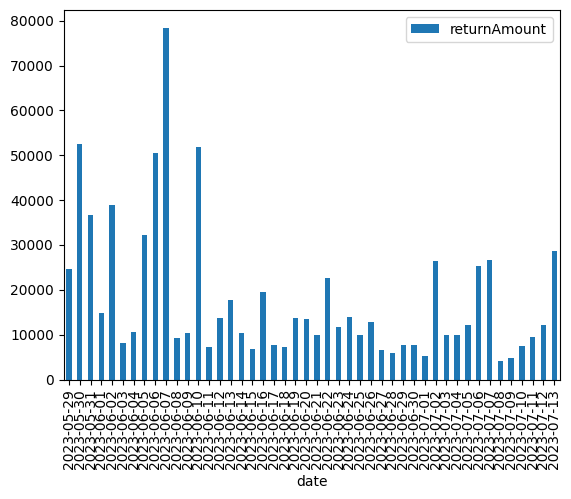

In [50]:
astro_sell[['date','returnAmount']].groupby('date').sum().plot(kind='bar')

<Axes: xlabel='date'>

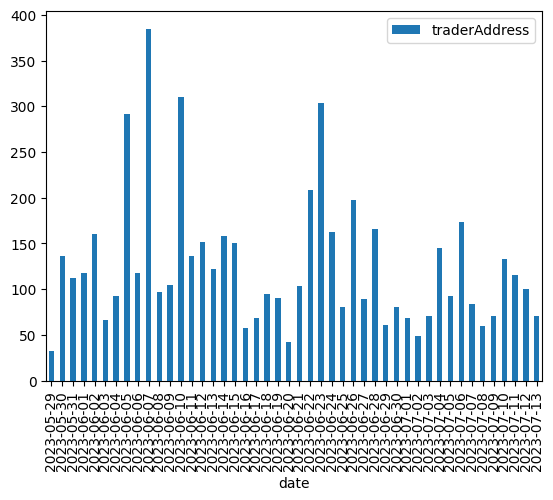

In [51]:
astro_sell[['date','traderAddress']].groupby('date').count().plot(kind='bar')

In [52]:
ttt_sell = astro_sell[astro_sell.date >= '2023-07-01'][['traderAddress','returnAmount','date']].groupby(['date','traderAddress']).sum().reset_index()
ttt_sell

,date,traderAddress,returnAmount
0,2023-07-01,terra100z8d5twsyrdmj2p9h282hu2q2q9c4jlmwxnfk,160.812448
1,2023-07-01,terra129atwlwg5dwuypmce92gz7y5rwzdyxlwd8ne9r,807.785527
2,2023-07-01,terra16es3hervf5a0xqwguylucuume9qwdd95tgphju,2.329615
3,2023-07-01,terra16lvlmvax0sczddapg3l7e8pk0g8r2janrefrz7,111.477911
4,2023-07-01,terra182vvhxz328vmc4v35e8lq0nw5t009nzgyseumd,36.377706
...,...,...,...
393,2023-07-13,terra1mghsnv4k45ajy5n5xxf8rdvu6fsdke0q8kwndh,2.030175
394,2023-07-13,terra1pw0fjdu8g9f6jz4suusxxentqj84ycv72nl2c3,616.601432
395,2023-07-13,terra1q3t4skfev9z0s49eu3af7j80wt50sr0t3lkt65,1367.664072
396,2023-07-13,terra1qvcatuge78ahzwkz653z3r6vy9jrfp070kzp9x,3692.292647


In [53]:
json_data = ttt_sell.to_json(orient='records')
with open("./data/astro/sellers_activity.json", 'w') as f:
    f.write(json_data)

In [54]:
ttt_buy = astro_buy[astro_buy.date >= '2023-07-01'][['traderAddress','returnAmount','date']].groupby(['date','traderAddress']).sum().reset_index()
ttt_buy

,date,traderAddress,returnAmount
0,2023-07-01,terra106nyprxug0vsx0qhxm5arnjjuqj6emnr2yn5nw,32.235351
1,2023-07-01,terra10zyz3728mtl44vvnxpm8gqlcf060vmxx8apae8,28.268817
2,2023-07-01,terra12mn0q75vz75fm53paa7wf0fxul5sgzz9yc9zer,9799.527480
3,2023-07-01,terra1302awc6j42tr7q68wxr463h8y2cqa00xktp26j,5479.735908
4,2023-07-01,terra14aqddykks6c8j0lfkk00n2xe4mf65dsssncutc,1751.111070
...,...,...,...
348,2023-07-13,terra1ydu9s5aa86w2p22d9y6r2way2tga5rja69p4cr,945.199706
349,2023-07-13,terra1yg57sejzex9mya0tzg95rqvyjfe2yrahys6xs7,35459.855700
350,2023-07-13,terra1z9urcdggs2mutsvprp66g69jv986t92tpu0emf,0.505951
351,2023-07-13,terra1zakne2kmp78fp477vaqxunj0tl27leqglkc2hw,86365.343071


In [55]:
json_data = ttt_buy.to_json(orient='records')
with open("./data/astro/buyers_activity.json", 'w') as f:
    f.write(json_data)